# Learning based methods

This is a model which takes a collection of images and figures out how to align them using an unsupervised approach. It is based on a paper by de Vos, Beredensen, Viergever, Sokooti, Staring, Isgum: [https://arxiv.org/pdf/1809.06130.pdf]().

In [1]:
import glob
import pandas as pd
import numpy as np

import tensorflow as tf
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

config = tf.ConfigProto()
# config.gpu_options.allocator_type = 'BFC'
tf.Session(config = config)

C:\Users\TWright\Anaconda3\envs\tensorflow-gpu\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 7290081096505623389
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 3389853696
locality {
  bus_id: 1
  links {
  }
}
incarnation: 15052020697823198648
physical_device_desc: "device: 0, name: GeForce GTX 970, pci bus id: 0000:01:00.0, compute capability: 5.2"
]


In [2]:
def load_img_paths(target):
    '''
    Retrieve the full path of all images in the dataset
    '''
    return glob.glob(target + '/*.tif')

data_dir = r'../data'
original_data_dir = data_dir + ('/learning')
all_files = pd.DataFrame(load_img_paths(original_data_dir))
train_paths = all_files[0].values.tolist()
train_paths[:5]

['../data/learning\\Tp26_Y000_X000_040.tif',
 '../data/learning\\Tp26_Y000_X001_040.tif',
 '../data/learning\\Tp26_Y000_X002_040.tif',
 '../data/learning\\Tp26_Y000_X003_040.tif',
 '../data/learning\\Tp26_Y000_X004_040.tif']

## Network

> A ConvNet design for affine image registration. The network analyzes pairs of fixed and moving images in separate pipelines. Ending each pipeline with global average pooling enables analysis of input images of different sizes, and allows concatenation with the fully connected layers that have a fixed number of nodes connected to 12 affne transformation parameter outputs.

> The two separate pipelines analyze input pairs of fixed and moving images and each consist of five alternating 3x3x3 convolution layers and 2x2x2 downsampling layers. The number of these layers may vary, depending on task complexity and input image size. The weights of the layers are shared between the two pipelines to limit the number of total parameters in the network.

> The Conv-Nets were initialized with Glorot's uniform distribution (Glorot and Bengio, 2010) and optimized with Adam.

> Subsequently, the network can be connected to a neural network work that will decode the relative orientations of the fixed and moving images and convert those to 12 affine transformation parameters: *three translation*, *three rotation*, *three scaling*, and *three shearing parameters*.

2D images -> 6 parameters

In [34]:
from keras import backend as K
from keras.layers.core import Dense
from keras.layers.convolutional import Convolution2D
from keras.layers import Input, Conv2D, AveragePooling2D, GlobalAveragePooling2D, concatenate, Reshape
from keras.models import Sequential, Model

from m_stn import BilinearInterpolation

def correlation_coefficient_loss(y_true, y_pred):
    '''
    Same as pearson coefficient
    https://stackoverflow.com/a/46620771
    '''
    x = y_true
    y = y_pred
    mx = K.mean(x)
    my = K.mean(y)
    xm, ym = x-mx, y-my
    r_num = K.sum(tf.multiply(xm,ym))
    r_den = K.sqrt(tf.multiply(K.sum(K.square(xm)), K.sum(K.square(ym))))
    r_den = K.maximumr_den(r_den, 1.0)
    r = r_num / r_den # this can produce NaN

    r = K.maximum(K.minimum(r, 1.0), -1.0)
    return 1 - K.square(r)

def SSD_loss(x, y):
    '''
    Sum squared differences
    '''
    return K.square(x - y)

def get_initial_weights(output_size):
    '''
    Initialize the weights as an identity matrix.
    '''
    b = np.zeros((2, 3), dtype='float32')
    b[0, 0] = 1
    b[1, 1] = 1
    W = np.zeros((output_size, 6), dtype='float32')
    weights = [W, b.flatten()]
    return weights

def dlir_layer(m1, m2, filters):
    '''
    alternating 3x3 convolution layers and 2x2 downsampling layers
    '''
    conv= Conv2D(filters, (3,3), activation='relu', padding='same')
    avg = AveragePooling2D() # default size is 2x2
    return avg(conv(m1)), avg(conv(m2))
    
def affine_pipeline(input_shape):
    '''
    five alternating 3x3 convolution layers and 2x2 downsampling layers
    Ending each pipeline with global average pooling
    '''
    filters = 32
    in1 = Input(shape=input_shape, name='reference_input')
    in2 = Input(shape=input_shape, name='moving_input')
    m1, m2 = dlir_layer(in1, in2, filters)
    m1, m2 = dlir_layer(m1, m2, filters)
    m1, m2 = dlir_layer(m1, m2, filters)
    m1, m2 = dlir_layer(m1, m2, filters)
    
    conv = Conv2D(filters, (3,3), activation='relu', padding='same')
    glob_avg = GlobalAveragePooling2D()
    
    return in1, in2, glob_avg(conv(m1)), glob_avg(conv(m2))
    
def my_DLIR(input_shape):
    '''
    Implement DLIR architecture
    '''
    input_1, input_2, moving_pipeline, reference_pipeline = affine_pipeline(input_shape)
    
    cat = concatenate([moving_pipeline, reference_pipeline])
    dense_size = 4096
    cat = Dense(dense_size, activation='relu')(cat)
    affine_transform = Dense(6, activation='linear', weights=get_initial_weights(dense_size), \
                             name='affine_params')(cat)
    image_output = BilinearInterpolation(input_shape[:-1])([input_2, affine_transform])
    return Model(inputs=[input_1, input_2], outputs=[image_output])


In [68]:
from keras.optimizers import Adam
from skimage.io import imread

def aspect_resize(newsize, shape):
    '''
    Given an integer and a shape, return a tuple with the longest side of the shape = newsize
    '''
    m = np.argmax(shape)
    if m == 0:
        return (newsize, int(shape[1] / (shape[0] / newsize)))
    return (int(shape[0] / (shape[1] / newsize)), newsize, 1)

orig_shape = imread(train_paths[0]).shape
img_size = aspect_resize(256, orig_shape)

my_model = my_DLIR(img_size)
lr = 1e-3
my_model.compile(loss='mse', optimizer=Adam(lr=lr))
# my_model.compile(loss=correlation_coefficient_loss, optimizer=Adam(lr=lr))
# my_model.compile(loss=SSD_loss, optimizer=Adam(lr=lr))
my_model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
moving_input (InputLayer)       (None, 195, 256, 1)  0                                            
__________________________________________________________________________________________________
reference_input (InputLayer)    (None, 195, 256, 1)  0                                            
__________________________________________________________________________________________________
conv2d_26 (Conv2D)              (None, 195, 256, 32) 320         reference_input[0][0]            
                                                                 moving_input[0][0]               
__________________________________________________________________________________________________
average_pooling2d_21 (AveragePo (None, 97, 128, 32)  0           conv2d_26[0][0]                  
          

In [69]:
from os import path
from keras.callbacks import ModelCheckpoint, Callback, EarlyStopping
from keras.preprocessing.image import img_to_array, load_img
from keras.utils import Sequence
from skimage.transform import resize, rotate


class LossHistory(Callback):
    def on_train_begin(self, logs={}):
        self.losses = []
        self.val_losses = []

    def on_batch_end(self, batch, logs={}):
        self.losses.append(logs.get('loss'))
        self.val_losses.append(logs.get('val_loss'))
        
        
def image_pair_coords(fname, ymin=0, ymax=7, xmin=0, xmax=14):
    '''
    get an image's pair in one for four directions
    '''
    im_coords = path.split(fname)[-1] \
                        .split('.')[0]    \
                        .split('_')[1:3]
    good_direction = False
    while not good_direction:
        #     direction = np.random.randint(0,4)
        direction = np.random.choice([1,3]) # horizontal only
        y_part = int(im_coords[0].split('Y')[1])
        x_part = int(im_coords[1].split('X')[1])
        if direction == 0:
            y_part -=1
        elif direction == 1:
            x_part +=1
        elif direction == 2:
            y_part +=1
        else: #direction == 3:
            x_part -=1
            
        if x_part >= xmin and x_part <= xmax and \
           y_part >= ymin and y_part <= ymax:
            good_direction = True

    ystr = str(y_part).rjust(2,'0')
    xstr = str(x_part).rjust(2,'0')
    fpath = path.split(fname)[:-1][0]
    next_fname = path.join(fpath, 'Tp26_Y0%s_X0%s_040.tif' % (ystr, xstr))
    return next_fname       
        
    
class DataGenerator(Sequence):
    '''
    Adapted from https://stanford.edu/~shervine/blog/keras-how-to-generate-data-on-the-fly.html
    Allows for multiprocessing in the fit generator
    '''

    def __init__(self, train_set, batch_size, im_size):
        self.train = train_set
        self.batch_size = batch_size
        self.im_size = im_size

    def __len__(self):
        return int(np.ceil(len(self.train) / float(self.batch_size)))

    def read_image(self, fname):
        return load_img(fname, target_size=self.im_size, grayscale=True)
    
    def read_images(self, f1, f2):
        x1 = load_img(f1, target_size=self.im_size, grayscale=True)
        x2 = load_img(f2, target_size=self.im_size, grayscale=True)
        return img_to_array(x1), img_to_array(x2)
    
    # Will output sequence of tuples (image, test) given a datapath
    def __getitem__(self, idx):
        X1 = np.zeros(shape=(batch_size, self.im_size[0], self.im_size[1], 1))
        X2 = np.zeros(shape=(batch_size, self.im_size[0], self.im_size[1], 1))
        y  = np.zeros(shape=(batch_size, self.im_size[0], self.im_size[1], 1))
        batch = self.train[idx * self.batch_size:(idx + 1) * self.batch_size]
        for j,fname in enumerate(batch):
            # to speed this up: preprocess the images so they aren't resized on the fly
            fname_moving = image_pair_coords(fname)
            x1,x2 = self.read_images(fname, fname_moving)
            X1[j] = x1
            X2[j] = x2
            y[j] = X1[j]
        return ([X1, X2], y)

    
class AugmentedDataGenerator(DataGenerator):
    '''
    Same as DataGenerator but augments data by overriding `read_image`.
    '''
    
#     def rand_augment(self, img):
#         minmax = 45 # in the range of -45 to 45
#         angle = np.random.randint(0, high=minmax) - (minmax*2)
#         return rotate(img, -angle)
    
    def read_images(self, f1, f2):
        x1 = img_to_array(load_img(f1, target_size=self.im_size, grayscale=True))
        x2 = img_to_array(load_img(f2, target_size=self.im_size, grayscale=True))
        flip_dir = np.random.choice([None, 0, 1])
        if flip_dir != None:
            x1 = np.flip(x1, flip_dir)
            x2 = np.flip(x2, flip_dir)
        return x1, x2
    
    
early_stopping = EarlyStopping(monitor='val_loss', patience=5, verbose=1, mode='auto')

# create weights file if it doesn't exist for ModelCheckpoint
from os import mkdir
try: 
    mkdir('tmp')
except FileExistsError:
    print('tmp directory already exists')

history = LossHistory()

tmp directory already exists


In [70]:
batch_size = 8
epochs     = 50

training_generator   = AugmentedDataGenerator(train_paths, batch_size, img_size)
# training_generator   = DataGenerator(train_paths, batch_size, img_size)

# descriptive weight file naming
checkpointer = ModelCheckpoint(filepath=('tmp/weights-%d-%d.hdf5' % 
                                         (batch_size, img_size[0])), 
                               verbose=1, save_best_only=True)

hist = my_model.fit_generator(training_generator, 
    epochs=epochs,
    workers=3,
    verbose=2,
    callbacks=[history, checkpointer, early_stopping]
)

Epoch 1/50
 - 4s - loss: 33047.1398
Epoch 2/50


C:\Users\TWright\Anaconda3\envs\tensorflow-gpu\lib\site-packages\keras\callbacks.py:435: RuntimeWarning: Can save best model only with val_loss available, skipping.
  'skipping.' % (self.monitor), RuntimeWarning)
C:\Users\TWright\Anaconda3\envs\tensorflow-gpu\lib\site-packages\keras\callbacks.py:526: RuntimeWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss
  (self.monitor, ','.join(list(logs.keys()))), RuntimeWarning


 - 1s - loss: 35192.3604
Epoch 3/50
 - 1s - loss: 35192.3612
Epoch 4/50
 - 1s - loss: 35192.3609
Epoch 5/50
 - 1s - loss: 35192.3607
Epoch 6/50
 - 1s - loss: 35192.3609
Epoch 7/50
 - 1s - loss: 35192.3607
Epoch 8/50
 - 1s - loss: 35192.3609
Epoch 9/50
 - 1s - loss: 35192.3609
Epoch 10/50
 - 1s - loss: 35192.3612
Epoch 11/50
 - 1s - loss: 35192.3602
Epoch 12/50
 - 1s - loss: 35192.3612
Epoch 13/50
 - 1s - loss: 35192.3612
Epoch 14/50
 - 1s - loss: 35192.3612
Epoch 15/50
 - 1s - loss: 35192.3609
Epoch 16/50
 - 1s - loss: 35192.3612
Epoch 17/50
 - 1s - loss: 35192.3607
Epoch 18/50
 - 1s - loss: 35192.3599
Epoch 19/50
 - 1s - loss: 35192.3609
Epoch 20/50
 - 1s - loss: 35192.3604
Epoch 21/50
 - 1s - loss: 35192.3609
Epoch 22/50
 - 1s - loss: 35192.3609
Epoch 23/50
 - 1s - loss: 35192.3612
Epoch 24/50
 - 1s - loss: 35192.3609
Epoch 25/50
 - 1s - loss: 35192.3607
Epoch 26/50
 - 1s - loss: 35192.3609
Epoch 27/50
 - 1s - loss: 35192.3607
Epoch 28/50
 - 1s - loss: 35192.3607
Epoch 29/50
 - 1s - 

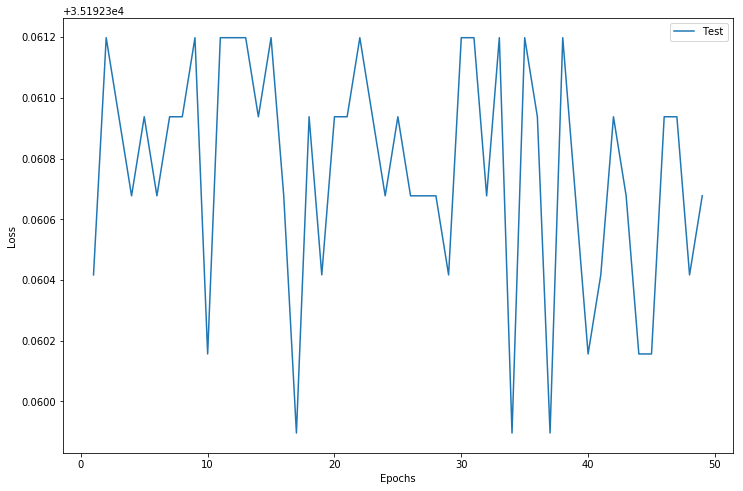

In [71]:
import matplotlib.pylab as plt
%matplotlib inline

plt.figure(figsize=(12,8))
plt.plot(hist.epoch[1:],hist.history['loss'][1:], label='Test')
# plt.plot(hist.epoch,hist.history['val_loss'],label='Validation',linestyle='--')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [72]:
f1 = train_paths[4]
f2 = train_paths[5]
print(f1,f2)

im1 = resize(imread(f1), img_size).reshape(-1, *img_size)
im2 = resize(imread(f2), img_size).reshape(-1, *img_size)
# im2 = resize(rotate(imread(train_paths[1]), 10), img_size).reshape(-1, *img_size)

im3 = my_model.predict([im1, im2])

../data/learning\Tp26_Y000_X004_040.tif ../data/learning\Tp26_Y000_X005_040.tif


C:\Users\TWright\Anaconda3\envs\tensorflow-gpu\lib\site-packages\skimage\transform\_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


[[ 0.9717497   0.02815789 -7.23211   ]
 [ 0.02819179  0.9717497   5.499233  ]]


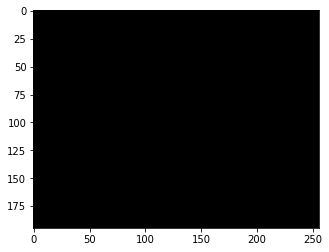

In [73]:
# a model which does not include the STN and outputs the predicted affine translation
intermediate_model = Model(inputs=[my_model.get_layer('reference_input').input, 
                                   my_model.get_layer('moving_input').input], 
                           outputs=[my_model.get_layer('affine_params').output])
M = intermediate_model.predict([im1, im2])[0].reshape(2,3)
M[0,2] *= img_size[1]
M[1,2] *= img_size[0]
print(M)
plt.imshow(im3[0][:,:,-1], cmap='gray')
plt.show()